In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# GLOBAL VARS
dataset_size = 11078
lr_faces = 5e-6
lr_scenes = 1e-4
lr_model = 1e-1
batch_size = 32
log_iter = 2
epochs = 30
load_model = False

In [3]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [4]:
# # try to read all the images to see if any are missing or corrupted
# df = pd.read_csv(os.path.join(findingemo_dir, "annotations_single.ann"))

# # Delete the columns: "user" and "index" and "datetime"
# if "user" in df.columns and "index" in df.columns and "datetime" in df.columns:
#     df = df.drop(columns=["user", "index", "datetime"])

# # remove leading slash from image_path
# if df["image_path"].iloc[0].startswith("/"):
#     df["image_path"] = df["image_path"].str.lstrip("/")

# # in the dataframe image_path column, change all the occurences of 'lmertens' to 'anon'
# df["image_path"] = df["image_path"].str.replace("lmertens", "anon", regex=False)
# # change the occurences of *, : ? in the image_path to _
# df["image_path"] = df["image_path"].str.replace("*", "_", regex=False)
# df["image_path"] = df["image_path"].str.replace(":", "_", regex=False)
# df["image_path"] = df["image_path"].str.replace("?", "_", regex=False)

# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)
# # Remove corrupted entries from dataframe
# df = df.drop(index=corrupted_indices).reset_index(drop=True)
# # save the cleaned dataframe as pickle
# df.to_pickle("clean_findingemo.pkl")

df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [5]:
# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)

In [6]:
# set device, move models and maps, set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0


In [8]:
len(df)

25867

In [9]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [10]:
df.tail()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
11073,Run_1/Adoring seniors festival/2DA8F2AD0000057...,Undefined,Seniors,2,5,Trust,"BodyLanguage,FacialExpression",1
11074,Run_2/Appalled forty-something winter/4AA05C5D...,Undefined,Adults,-3,4,Anger,"BodyLanguage,FacialExpression,Staging",0
11075,Run_2/Content soldiers beach/hcpd-training.jpg,Undefined,Adults,2,5,Vigilance,"BodyLanguage,ConflictCtxtPerson,Context,Facial...",4
11076,Run_2/Suffering students army/180130-Patriot-R...,Undefined,"Youth,Adults",1,2,Interest,"BodyLanguage,FacialExpression",4
11077,Run_2/Shaken seniors library/1-doctor-shaking-...,Watermark,"Adults,Seniors",1,3,Trust,"Context,FacialExpression,Staging",0


In [11]:
df['emotion'] = df['emotion'].str.lower()

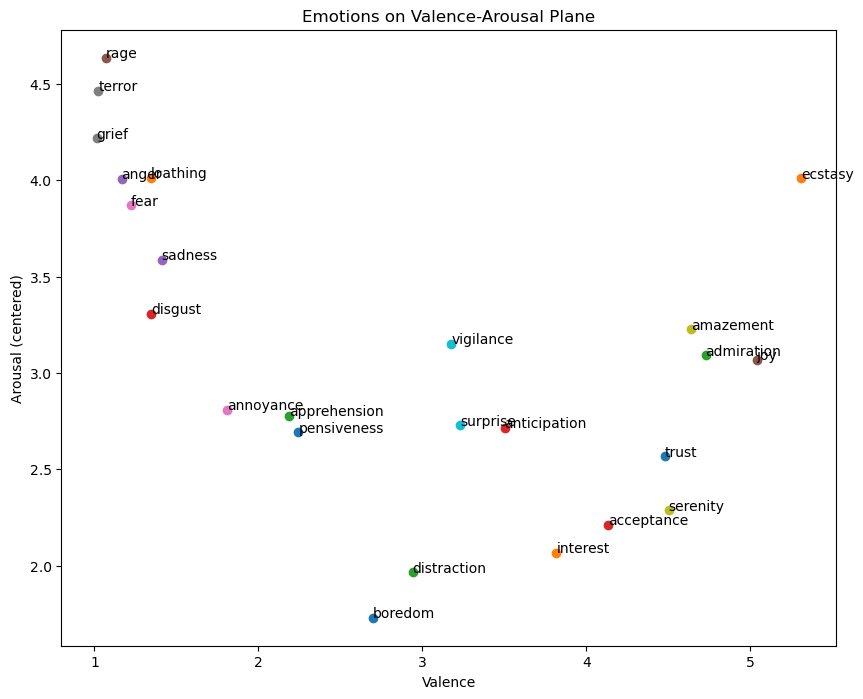

In [12]:
plt.figure(figsize=(10, 8))
for emo in df['emotion'].unique():
    subset = df[df['emotion'] == emo.lower()]
    avg_valence = subset['valence'].mean() + 3
    avg_arousal = subset['arousal'].mean()
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)
plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title('Emotions on Valence-Arousal Plane')
plt.show()

In [13]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,interest,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,interest,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,interest,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,apprehension,ConflictCtxtPerson,0


In [14]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [15]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             1754
interest        1141
serenity         844
anticipation     748
acceptance       636
apprehension     588
vigilance        581
trust            522
ecstasy          516
sadness          462
admiration       461
annoyance        401
anger            394
grief            376
pensiveness      300
fear             277
boredom          263
rage             154
distraction      151
terror           131
surprise         118
disgust          107
amazement         83
loathing          70
Name: count, dtype: int64

In [16]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 8862
Test indices length: 2216


In [17]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [18]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig


emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [19]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces_5"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
train_faces_dataset = FacesDataset(train_indices)
test_faces_dataset = FacesDataset(test_indices)

In [20]:
class FaceNet(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)

        x = x.to(next(self.parameters()).device)
        outputs = self.base_model(x)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        return probs
    
face_model = FaceNet(face_model_base)
face_model.to(DEVICE)
print("Face model initialized")

Face model initialized


In [21]:
# Freeze embeddings
for param in face_model_base.vit.embeddings.parameters():
    param.requires_grad = False

# Freeze encoder layers 0–9
for layer in face_model_base.vit.encoder.layer[:10]:
    for param in layer.parameters():
        param.requires_grad = False

# UNFREEZE encoder layers 10 and 11
for layer in face_model_base.vit.encoder.layer[10:]:
    for param in layer.parameters():
        param.requires_grad = True

# Freeze final layernorm
for param in face_model_base.vit.layernorm.parameters():
    param.requires_grad = True   

# Train classifier head
for param in face_model_base.classifier.parameters():
    param.requires_grad = True

trainable = [name for name, p in face_model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable)

Trainable parameters: ['base_model.vit.encoder.layer.10.attention.attention.query.weight', 'base_model.vit.encoder.layer.10.attention.attention.query.bias', 'base_model.vit.encoder.layer.10.attention.attention.key.weight', 'base_model.vit.encoder.layer.10.attention.attention.key.bias', 'base_model.vit.encoder.layer.10.attention.attention.value.weight', 'base_model.vit.encoder.layer.10.attention.attention.value.bias', 'base_model.vit.encoder.layer.10.attention.output.dense.weight', 'base_model.vit.encoder.layer.10.attention.output.dense.bias', 'base_model.vit.encoder.layer.10.intermediate.dense.weight', 'base_model.vit.encoder.layer.10.intermediate.dense.bias', 'base_model.vit.encoder.layer.10.output.dense.weight', 'base_model.vit.encoder.layer.10.output.dense.bias', 'base_model.vit.encoder.layer.10.layernorm_before.weight', 'base_model.vit.encoder.layer.10.layernorm_before.bias', 'base_model.vit.encoder.layer.10.layernorm_after.weight', 'base_model.vit.encoder.layer.10.layernorm_after.

In [22]:
face_network = Network(face_model, "face_model", batching=True)
face_network.optimizer = torch.optim.Adam(face_model.parameters(), lr=lr_faces)

In [23]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)

print("Loaded pretrained models")

Loaded pretrained models


In [24]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img

In [25]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        img_path = df.loc[i]['image_path']
        extension = img_path.rsplit('.', 1)[1]
        img_path_no_ext = img_path.rsplit('.', 1)[0]
        tensor = super().__getitem__(img_path_no_ext, extension = extension)
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

train_scenes_dataset = SceneDataset(train_indices)
test_scenes_dataset = SceneDataset(test_indices)

In [26]:
# def calculate_places_priors(threshold = 0.10, indices = train_indices):
#     scene_model_base.eval()
#     scene_dict = {scene_name: [] for scene_name in scene_categories}
#     for sample_idx in tqdm(indices, desc=f"Calculating priors over {len(indices)} samples"):
#         scene_tensor = train_scenes_dataset[(sample_idx,)]
#         row = df.loc[sample_idx]
#         valence = row['valence'] + 3
#         arousal = row['arousal']
#         with torch.no_grad():
#             mapped_output = scene_model_base(scene_tensor.unsqueeze(0))[0]
#             mapped_softmax = torch.softmax(mapped_output, dim=0)

#         top3_scenes = torch.topk(mapped_softmax, 3)
        
#         # Now extract the scene names and probabilities
#         for prob, idx in zip(top3_scenes.values.cpu(), top3_scenes.indices.cpu()):
#             scene_name = scene_categories[idx.item()]
#             prob_value = prob.item()
#             if prob_value > threshold:
#                 scene_dict[scene_name].append((valence, arousal))

#     # Take the average of valence and arousal for each scene
#     scene_priors = {}
#     for scene_name, va_list in scene_dict.items():
#         if len(va_list) > 0:
#             nr_samples = len(va_list)
#             avg_valence = sum([va[0] for va in va_list]) / nr_samples
#             avg_arousal = sum([va[1] for va in va_list]) / nr_samples
#             scene_priors[scene_name] = (avg_valence, avg_arousal, nr_samples)
#         else:
#             scene_priors[scene_name] = (None, None, 0)

#     return scene_priors

# scene_priors = calculate_places_priors(threshold=0.10, indices=train_indices)

# # Save scene_priors to excel
# cluster_labels = []
# for scene_name in scene_categories:
#     valence, arousal, nr_samples = scene_priors[scene_name]
#     cluster_labels.append({
#         "scene_category": scene_name,
#         "valence": valence,
#         "arousal": arousal,
#         "nr_samples": nr_samples
#     })

# df_priors = pd.DataFrame(cluster_labels)

# output_path = os.path.join(data_dir, "scene_priors.xlsx")
# df_priors.to_excel(output_path, index=False)

# print(f"\nscene_priors.xlsx saved to: {output_path}")

In [27]:
# Load scene priors from excel and change the nan values to None
scene_priors = {}
df_loaded = pd.read_excel(os.path.join(data_dir, "scene_priors.xlsx"))
for _, row in df_loaded.iterrows():
    scene_name = row['scene_category']
    valence = row['valence'] if not pd.isna(row['valence']) else None
    arousal = row['arousal'] if not pd.isna(row['arousal']) else None
    nr_samples = row['nr_samples'] if not pd.isna(row['nr_samples']) else None
    scene_priors[scene_name] = (valence, arousal, nr_samples)

In [28]:
scene_priors

{'airfield': (4.0, 3.0, 2),
 'airplane_cabin': (3.05982905982906, 3.025641025641026, 117),
 'airport_terminal': (2.952380952380953, 2.190476190476191, 42),
 'alcove': (4.0, 1.0, 1),
 'alley': (3.130434782608696, 2.608695652173913, 23),
 'amphitheater': (2.905511811023622, 3.125984251968504, 127),
 'amusement_arcade': (3.636363636363636, 3.0, 11),
 'amusement_park': (3.324324324324324, 3.333333333333333, 111),
 'apartment_building_outdoor': (4.0, 2.5, 2),
 'aquarium': (3.214285714285714, 2.5, 14),
 'aqueduct': (2.0, 2.666666666666667, 3),
 'arcade': (4.2, 2.2, 5),
 'arch': (6.0, 4.0, 1),
 'archaelogical_excavation': (3.089783281733746, 2.705882352941177, 323),
 'archive': (3.836734693877551, 2.653061224489796, 49),
 'arena_hockey': (3.512820512820513, 2.974358974358974, 39),
 'arena_performance': (3.979430379746836, 3.170886075949367, 632),
 'arena_rodeo': (3.411764705882353, 2.647058823529412, 34),
 'army_base': (2.754067584480601, 2.991864831038798, 1598),
 'art_gallery': (3.5625, 2.4

In [40]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

def cluster_places_categories_weighted(scene_priors, n_clusters=10):
    valid_scenes = []
    features = []
    weights = []

    # Extract valid scenes
    for scene_name, (valence, arousal, nr_samples) in tqdm(scene_priors.items(), desc="Filtering scenes"):
        if valence is not None and arousal is not None:
            valid_scenes.append(scene_name)
            features.append([valence, arousal])
            weights.append(nr_samples)

    features = np.array(features)
    weights = np.array(weights)

    print(f"Valid scenes: {len(valid_scenes)}/{len(scene_priors)}")
    print(f"Total samples: {weights.sum()}")

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # True weighted KMeans
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42,
        n_init=10,
    )

    # Fit with sample_weight (this is TRUE weighted K-Means)
    kmeans.fit(features_scaled, sample_weight=weights)

    # Assign cluster labels directly
    labels = kmeans.labels_

    # Build dictionary mapping scene → cluster
    cluster_labels = {
        scene: int(cluster)
        for scene, cluster in zip(valid_scenes, labels)
    }

    # Convert centers back to original valence/arousal scale
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

    return cluster_labels, cluster_centers, features, valid_scenes, weights

# Run clustering
cluster_labels, cluster_centers, scene_features, valid_scenes, scene_weights = cluster_places_categories_weighted(
    scene_priors, 
    n_clusters=9)

# Print cluster statistics
print("\nCluster Statistics:")
for cluster_id in range(len(cluster_centers)):
    scenes_in_cluster = [s for s, c in cluster_labels.items() if c == cluster_id]
    total_samples = sum(scene_priors[s][2] for s in scenes_in_cluster)
    avg_valence = cluster_centers[cluster_id][0]
    avg_arousal = cluster_centers[cluster_id][1]
    print(f"Cluster {cluster_id}: {len(scenes_in_cluster)} scenes, {total_samples} samples")
    print(f"  Center: Valence={avg_valence:.2f}, Arousal={avg_arousal:.2f}")
    print()


Filtering scenes: 100%|██████████| 365/365 [00:00<00:00, 358949.81it/s]

Valid scenes: 330/365
Total samples: 41175

Cluster Statistics:
Cluster 0: 21 scenes, 537 samples
  Center: Valence=2.16, Arousal=3.52

Cluster 1: 47 scenes, 7550 samples
  Center: Valence=3.36, Arousal=2.96

Cluster 2: 25 scenes, 4422 samples
  Center: Valence=2.78, Arousal=2.90

Cluster 3: 52 scenes, 6432 samples
  Center: Valence=3.88, Arousal=3.19

Cluster 4: 31 scenes, 4816 samples
  Center: Valence=3.87, Arousal=2.81

Cluster 5: 52 scenes, 4717 samples
  Center: Valence=3.68, Arousal=2.47

Cluster 6: 39 scenes, 5507 samples
  Center: Valence=3.27, Arousal=2.65

Cluster 7: 18 scenes, 5073 samples
  Center: Valence=2.59, Arousal=3.15

Cluster 8: 45 scenes, 2121 samples
  Center: Valence=4.21, Arousal=2.55



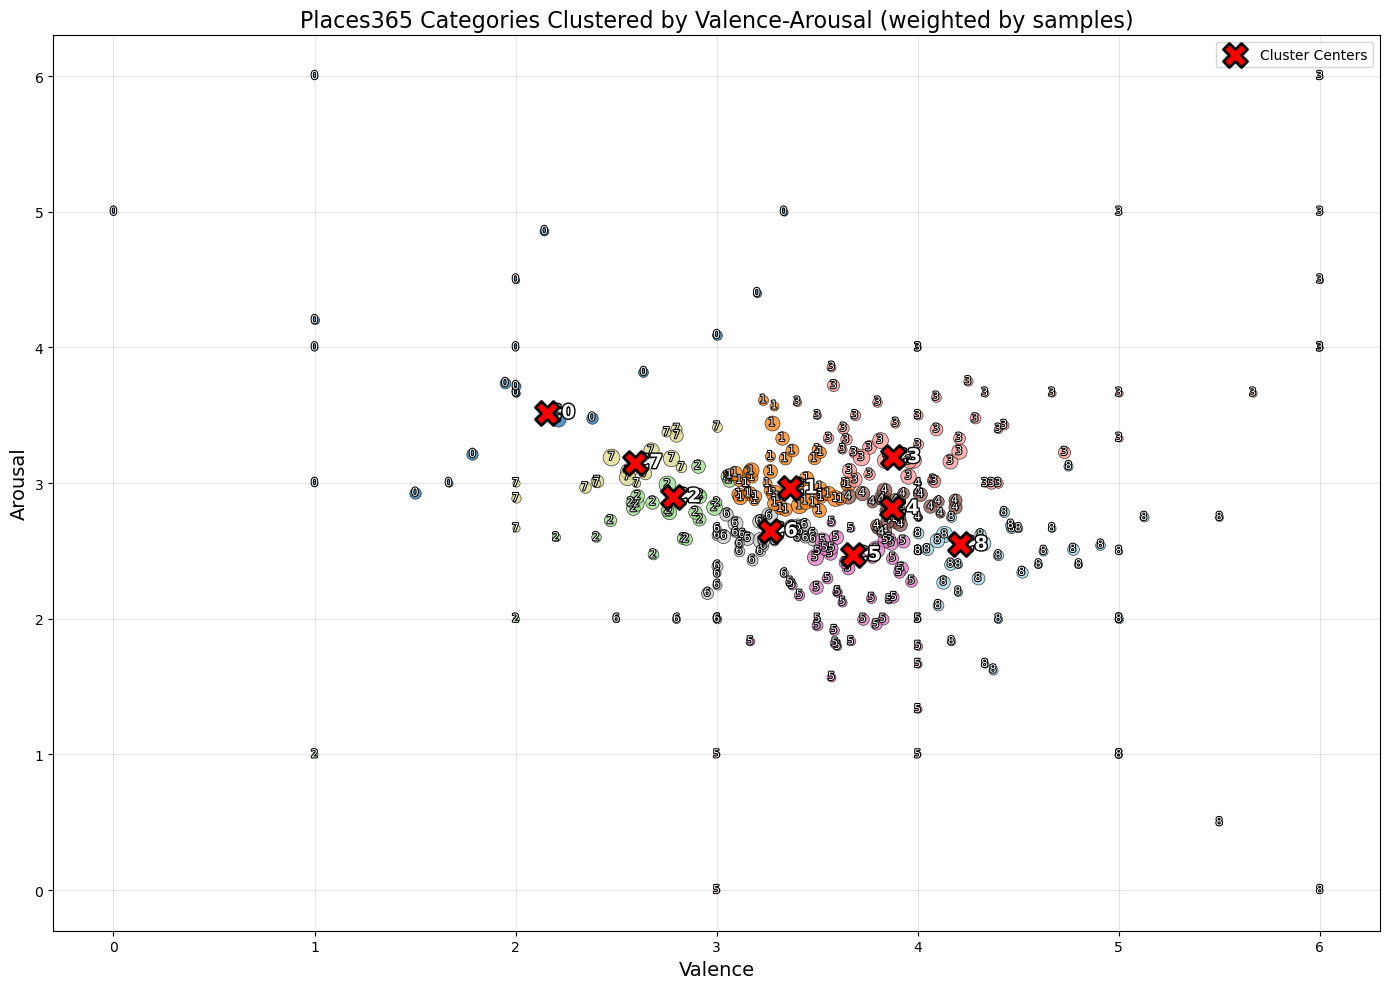


DETAILED CLUSTER BREAKDOWN

CLUSTER 0
Center: Valence=2.16, Arousal=3.52
Number of scenes: 21
Total samples: 537

All scenes in this cluster:
--------------------------------------------------------------------------------
  • attic                          | V=1.67, A=3.00, N=   3
  • auto_factory                   | V=1.50, A=2.93, N=  28
  • canal_natural                  | V=2.00, A=3.67, N=   3
  • catacomb                       | V=2.00, A=4.50, N=   2
  • cockpit                        | V=3.00, A=4.09, N=  11
  • courthouse                     | V=2.00, A=4.00, N=   1
  • desert_sand                    | V=2.14, A=4.86, N=   7
  • grotto                         | V=1.00, A=6.00, N=   1
  • hot_spring                     | V=1.95, A=3.74, N=  19
  • ice_floe                       | V=3.20, A=4.40, N=   5
  • junkyard                       | V=1.79, A=3.21, N=  28
  • landfill                       | V=2.21, A=3.47, N= 368
  • moat_water                     | V=2.00, A=3.67, N= 

In [41]:
# Visualize clusters
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects
def visualize_clusters_2d(cluster_labels, cluster_centers, scene_features, valid_scenes, scene_weights, scene_priors):
    """2D visualization of clusters on valence-arousal plane with cluster ID labels on each point."""
    plt.figure(figsize=(14, 10))
    
    # Colors for each cluster
    colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_centers)))
    
    for i, scene_name in enumerate(valid_scenes):
        cluster_id = cluster_labels[scene_name]
        valence, arousal = scene_features[i]
        size = np.log1p(scene_weights[i]) * 20
        
        # Scatter point
        plt.scatter(valence, arousal, 
                    c=[colors[cluster_id]], 
                    s=size, 
                    alpha=0.75, 
                    edgecolors='black', 
                    linewidth=0.5)
        
        # Add cluster ID text next to the point
        plt.text(valence, arousal, str(cluster_id),
                 fontsize=8, 
                 ha='center', va='center',
                 color='white',
                 path_effects=[
                     mpl.patheffects.Stroke(linewidth=1.5, foreground='black'),
                     mpl.patheffects.Normal()
                 ])
    
    # Plot cluster centers
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
                c='red', s=300, marker='X', edgecolors='black', linewidth=2, 
                label='Cluster Centers', zorder=5)
    
    # Annotate cluster centers
    for i, (v, a) in enumerate(cluster_centers):
        plt.annotate(f'C{i}', (v, a), fontsize=14, fontweight='bold', 
                     ha='left', va='center', color='white',
                     path_effects=[
                         mpl.patheffects.Stroke(linewidth=2, foreground='black'),
                         mpl.patheffects.Normal()
                     ])
    
    plt.xlabel('Valence', fontsize=14)
    plt.ylabel('Arousal', fontsize=14)
    plt.title('Places365 Categories Clustered by Valence-Arousal (weighted by samples)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print all scenes per cluster
    print("\n" + "="*80)
    print("DETAILED CLUSTER BREAKDOWN")
    print("="*80)
    for cluster_id in range(len(cluster_centers)):
        scenes_in_cluster = sorted([s for s, c in cluster_labels.items() if c == cluster_id])
        total_samples = sum(scene_priors[s][2] for s in scenes_in_cluster)
        avg_valence = cluster_centers[cluster_id][0]
        avg_arousal = cluster_centers[cluster_id][1]
        
        print(f"\n{'='*80}")
        print(f"CLUSTER {cluster_id}")
        print(f"{'='*80}")
        print(f"Center: Valence={avg_valence:.2f}, Arousal={avg_arousal:.2f}")
        print(f"Number of scenes: {len(scenes_in_cluster)}")
        print(f"Total samples: {total_samples}")
        print(f"\nAll scenes in this cluster:")
        print("-" * 80)
        
        for scene_name in scenes_in_cluster:
            v, a, n = scene_priors[scene_name]
            print(f"  • {scene_name:30s} | V={v:.2f}, A={a:.2f}, N={n:4d}")
        print()

# Call the updated function
visualize_clusters_2d(cluster_labels, cluster_centers, scene_features, valid_scenes, scene_weights, scene_priors)

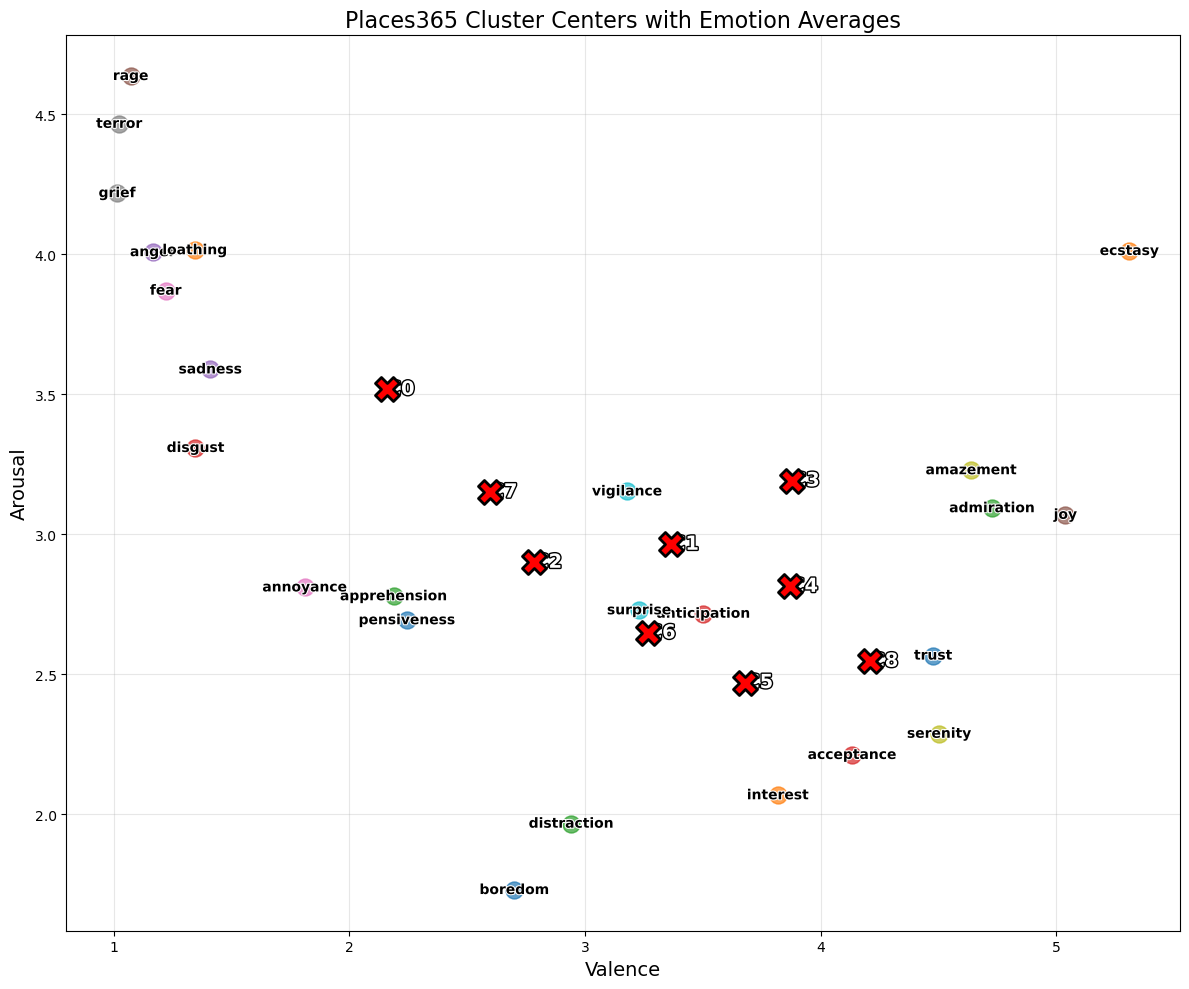

In [43]:
# Now create a scatterplots of the cluster centers together with the valence arousal points of the emotions
def plot_clusters_with_emotions(cluster_centers):
    plt.figure(figsize=(12, 10))
    
    # Plot cluster centers
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
                c='red', s=300, marker='X', edgecolors='black', linewidth=2, 
                label='Cluster Centers', zorder=5)
    
    # Annotate cluster centers
    for i, (v, a) in enumerate(cluster_centers):
        plt.annotate(f'C{i}', (v, a), fontsize=14, fontweight='bold', 
                     ha='left', va='center', color='white',
                     path_effects=[
                         mpl.patheffects.Stroke(linewidth=2, foreground='black'),
                         mpl.patheffects.Normal()
                     ])
    
    # Plot emotion points
    for emo in df['emotion'].unique():
        subset = df[df['emotion'] == emo.lower()]
        avg_valence = subset['valence'].mean() + 3
        avg_arousal = subset['arousal'].mean()
        plt.scatter(avg_valence, avg_arousal, label=emo, s=150, alpha=0.7)
        plt.text(avg_valence, avg_arousal, emo,
                 fontsize=10, fontweight='bold',
                 ha='center', va='center',
                 color='black',
                 path_effects=[
                     mpl.patheffects.Stroke(linewidth=1.5, foreground='white'),
                     mpl.patheffects.Normal()
                 ])
    
    plt.xlabel('Valence', fontsize=14)
    plt.ylabel('Arousal', fontsize=14)
    plt.title('Places365 Cluster Centers with Emotion Averages', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_clusters_with_emotions(cluster_centers)

In [32]:
# # Based on the distance between the cluster centers and the emotion averages, we can assign probabilities of each cluster belonging to each emotion that we can use in our prolog model
# emotion_averages = {}
# for leaf in EMOTION_SETS:
#     emo = leaf[1]
#     subset = df[df['emo8'] == emo.lower()]
#     avg_valence = subset['valence'].mean() + 3
#     avg_arousal = subset['arousal'].mean()
#     emotion_averages[emo.lower()] = (avg_valence, avg_arousal)

# # For each cluster center, calculate distance to each emotion average
# cluster_emotion_probs = {}
# for cluster_id, (cv, ca) in enumerate(cluster_centers):
#     distances = {}
#     for emo, (ev, ea) in emotion_averages.items():
#         dist = np.sqrt((cv - ev) ** 2 + (ca - ea) ** 2)
#         distances[emo] = dist
#     # Convert distances to probabilities (inverse distance)
#     total_inv_dist = sum(1 / d for d in distances.values())
#     probs = {emo: (1 / d) / total_inv_dist for emo, d in distances.items()}
#     cluster_emotion_probs[cluster_id] = probs

In [33]:
# cluster_emotion_probs

In [34]:
# def normalize_and_round_2_decimals(prob_dict):
#     """
#     Normalize a dict of probabilities and round to 2 decimals.
#     Ensures final rounded values sum to exactly 1.00 by adjusting the last key.
#     """
#     # Normalize
#     total = sum(prob_dict.values())
#     normalized = {k: v / total for k, v in prob_dict.items()}

#     # Round to 2 decimals
#     rounded = {k: round(v, 2) for k, v in normalized.items()}

#     # Fix rounding drift so sum = 1.00
#     drift = 1.00 - sum(rounded.values())
#     # Add drift to the last key (sorted for reproducibility)
#     last_key = list(sorted(rounded.keys()))[-1]
#     rounded[last_key] = round(rounded[last_key] + drift, 2)

#     return rounded

# # Create the prolog file
# prolog_file_name = "model5.pl"
# prolog_file_path = os.path.join(prolog_dir, prolog_file_name)
# with open(prolog_file_path, "w") as f:

#     f.write("nn(face_model, [Face], Emotion,\n")
#     f.write("   [angry, disgust, fear, happy, neutral, sad, surprise]) ::\n")
#     f.write("   face_emotion(Face, Emotion).\n\n")

#     f.write("nn(scene_model, [Scene], Cluster, [0,1,2,3,4,5,6,7,8]) ::\n")
#     f.write("   scene_cluster(Scene, Cluster).\n\n")

#     f.write("final_emotion_0([], SceneTensor, FinalEmo) :-\n")
#     f.write("    scene_cluster(SceneTensor, Cluster),\n")
#     f.write("    cluster_to_emotion(Cluster, FinalEmo).\n\n")

#     for cluster_id, emo_dict in cluster_emotion_probs.items():
#             rounded_probs = normalize_and_round_2_decimals(emo_dict)
#             emotions_list = list(rounded_probs.items())
            
#             for idx, (emotion, prob) in enumerate(emotions_list):
#                 is_last = (idx == len(emotions_list) - 1)
#                 terminator = "." if is_last else ";"
                
#                 # if prob > 0.15:
#                 #     # Make it trainable:
#                 #     f.write(f"t({prob:.2f})::cluster_to_emotion({cluster_id}, {emotion}){terminator}\n")
#                 # else:
#                 f.write(f"{prob:.2f}::cluster_to_emotion({cluster_id}, {emotion}){terminator}\n")

#             f.write("\n")

# print("Prolog file written to:", prolog_file_path)
    

In [35]:
cluster_names = ["industrial_stress",
                 "busy_social",
                 "functional_work",
                 "active_recreation",
                 "community",
                 "indoor",
                 "institutional_public",
                 "crowded_urban",
                 "leisure"]

# Find categories not in cluster_labels (those without valence/arousal data)
unassigned_categories = [cat for cat in scene_categories if cat not in cluster_labels]

# Randomly assign them to clusters
random.seed(42)  # For reproducibility
for cat in unassigned_categories:
    random_cluster = random.randint(0, len(cluster_centers) - 1)
    cluster_labels[cat] = random_cluster

# Verify all categories are now assigned
assert len(cluster_labels) == len(scene_categories), "Not all categories are assigned!"

# Update the cluster_dict with all categories
cluster_dict = {}
for cluster_id in range(len(cluster_centers)):
    scenes_in_cluster = sorted([s for s, c in cluster_labels.items() if c == cluster_id])
    cluster_dict[cluster_names[cluster_id]] = scenes_in_cluster
    print(f"Cluster {cluster_id} ({cluster_names[cluster_id]}): {len(scenes_in_cluster)} scenes")

# Convert to DataFrame and save
max_len = max(len(scenes) for scenes in cluster_dict.values())
for key in cluster_dict:
    scenes = cluster_dict[key]
    cluster_dict[key] = scenes + [""] * (max_len - len(scenes))

df_clusters = pd.DataFrame(cluster_dict)

# Save to Excel file
output_path = os.path.join(data_dir, "scene_clusters.xlsx")
df_clusters.to_excel(output_path, index=False)

print(f"\nscene_clusters.xlsx saved to: {output_path}")

Cluster 0 (industrial_stress): 26 scenes
Cluster 1 (busy_social): 53 scenes
Cluster 2 (functional_work): 28 scenes
Cluster 3 (active_recreation): 59 scenes
Cluster 4 (community): 34 scenes
Cluster 5 (indoor): 54 scenes
Cluster 6 (institutional_public): 43 scenes
Cluster 7 (crowded_urban): 19 scenes
Cluster 8 (leisure): 49 scenes

scene_clusters.xlsx saved to: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\scene_clusters.xlsx


In [36]:
# read the csv file from the data folder
categories_365_path = os.path.join(data_dir, "scene_clusters.xlsx")

# read as csv
categories_365_df = pd.read_excel(categories_365_path)
categories_365_df.head()

,industrial_stress,busy_social,functional_work,active_recreation,community,indoor,institutional_public,crowded_urban,leisure
0,attic,amusement_arcade,airplane_cabin,arch,airfield,alcove,airport_terminal,aqueduct,apartment_building_outdoor
1,auto_factory,amusement_park,amphitheater,arena_performance,archive,art_gallery,alley,basement,arcade
2,bank_vault,arena_hockey,army_base,athletic_field_outdoor,ball_pit,art_studio,aquarium,bazaar_outdoor,art_school
3,canal_natural,atrium_public,assembly_line,badlands,bamboo_forest,artists_loft,archaelogical_excavation,bullring,balcony_exterior
4,catacomb,auditorium,boat_deck,bakery_shop,barn,banquet_hall,arena_rodeo,cemetery,balcony_interior


In [37]:
# From the dataframe, create a dictionary that maps every category to its broader category (column where it belongs)
category_mapping = {}
for col in categories_365_df.columns:
    for category in categories_365_df[col].dropna().tolist():
        category_mapping[category] = col

mapped_categories = list(dict.fromkeys(category_mapping.values()))
print("Mapped Categories:", mapped_categories)

Mapped Categories: ['industrial_stress', 'busy_social', 'functional_work', 'active_recreation', 'community', 'indoor', 'institutional_public', 'crowded_urban', 'leisure']


In [38]:
# Check for all the columns in the excel (without the first row) if there are no duplicates and the length is 365
cats = []
for col in categories_365_df.columns:
    unique_cats = categories_365_df[col].dropna().tolist()
    cats.extend(unique_cats)
unique_set = set(cats)
print("Total unique categories mapped:", len(unique_set))  # Should be 365

Total unique categories mapped: 365


In [39]:
errors = 0
# Check if all the 365 categories are in the mapping
for cat in scene_categories:
    if cat not in category_mapping:
        print("Category not found in mapping:", cat)
        errors += 1

# check if all keys in category_mapping are in scene_categories
for cat in category_mapping.keys():
    if cat not in scene_categories:
        print("Category in mapping not found in scene categories:", cat)
        errors += 1

assert(errors == 0)

In [40]:
# Build mapping matrix with deterministic column order and float dtype
map_365 = torch.zeros((365, len(mapped_categories)), dtype=torch.float32)
for i, cat in enumerate(scene_categories):
    coarse = category_mapping[cat]
    coarse_idx = mapped_categories.index(coarse)
    map_365[i, coarse_idx] = 1.0

In [41]:
def get_mapped_category(scene_idx_365):
    # print the name of the 365 category
    mapped = map_365[scene_idx_365]
    mapped_idx = torch.argmax(mapped).item()
    print(scene_categories[scene_idx_365], "->", mapped_categories[mapped_idx])

In [42]:
class SceneNet(nn.Module):
    def __init__(self, pretrained_model, map_365 = map_365):
        super().__init__()
        self.base = pretrained_model
        self.register_buffer("map_365", map_365.clone().float())

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)

        x = x.to(next(self.parameters()).device)
        logits = self.base(x)
        probs = torch.softmax(logits, dim=1)
        mapped_probs = torch.matmul(probs, self.map_365)
        return mapped_probs

scene_model = SceneNet(pretrained_model=scene_model_base).to(DEVICE)      

for name, param in scene_model.base.named_parameters():

    # Freeze low and mid-level layers
    if name.startswith(("conv1", "bn1", "layer1", "layer2", "layer3")):
        param.requires_grad = False

    # UNFREEZE layer4 (important!)
    elif name.startswith("layer4"):
        param.requires_grad = True

    # UNFREEZE the classification head
    elif name.startswith("fc"):
        param.requires_grad = True


trainable = [name for name, p in scene_model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable)

scene_network = Network(scene_model, "scene_model", batching=True)
scene_network.optimizer = torch.optim.Adam(scene_model.parameters(), lr=lr_scenes)  

Trainable parameters: ['base.layer4.0.conv1.weight', 'base.layer4.0.bn1.weight', 'base.layer4.0.bn1.bias', 'base.layer4.0.conv2.weight', 'base.layer4.0.bn2.weight', 'base.layer4.0.bn2.bias', 'base.layer4.0.downsample.0.weight', 'base.layer4.0.downsample.1.weight', 'base.layer4.0.downsample.1.bias', 'base.layer4.1.conv1.weight', 'base.layer4.1.bn1.weight', 'base.layer4.1.bn1.bias', 'base.layer4.1.conv2.weight', 'base.layer4.1.bn2.weight', 'base.layer4.1.bn2.bias', 'base.fc.weight', 'base.fc.bias']


In [43]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [44]:
faces_dir = os.path.join(findingemo_dir, "faces_5")
os.makedirs(faces_dir, exist_ok=True)

csv_path = os.path.join(findingemo_dir, "face_boxes_5.csv")

# Create and open CSV file for writing
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    # header row
    writer.writerow(["index", "image_path", "face_rank", "x1", "y1", "x2", "y2", "score", "crop_path"])

    # ========================================
    # Iterate over the dataframe and process each image
    # ========================================
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Detecting faces"):
        img_path = os.path.join(findingemo_dir, row["image_path"])

        try:
            detections = RetinaFace.detect_faces(img_path)
        except Exception as e:
            print(f"[Warning] Could not process {img_path}: {e}")
            continue

        # Skip images without faces
        if not detections or isinstance(detections, str):
            continue

        # Collect all detected faces
        faces = []
        for det in detections.values():
            x1, y1, x2, y2 = det["facial_area"]
            area = (x2 - x1) * (y2 - y1)
            faces.append({
                "coords": (x1, y1, x2, y2),
                "score": det["score"],
                "area": area
            })

        # Sort faces by area (largest first) and keep top 5
        faces = sorted(faces, key=lambda x: x["area"], reverse=True)[:5]

        # Crop and save top faces
        img = Image.open(img_path).convert("RGB")
        for i, face in enumerate(faces):
            x1, y1, x2, y2 = face["coords"]
            crop = img.crop((x1, y1, x2, y2)).resize((224, 224))
            crop_name = f"img_{idx}_face_{i}.jpg"
            crop_path = os.path.join(faces_dir, crop_name)
            crop.save(crop_path, "JPEG", quality=90)

            # Write bounding box info to CSV
            writer.writerow([
                idx,                      # image index
                row["image_path"],        # relative image path
                i,                        # face rank (0=largest)
                x1, y1, x2, y2,           # bounding box coordinates
                face["score"],            # detection confidence
                crop_path                 # saved crop file
            ])

print(f"Finished! Cropped faces saved in: {faces_dir}")
print(f"Bounding box CSV saved at: {csv_path}")


Detecting faces:  43%|████▎     | 11079/25867 [5:36:19<7:28:55,  1.82s/it]


KeyboardInterrupt: 

In [ ]:
# import os
# import csv
# from tqdm import tqdm
# from PIL import Image
# from retinaface import RetinaFace

# faces_dir = os.path.join(findingemo_dir, "faces")
# os.makedirs(faces_dir, exist_ok=True)

# csv_path = os.path.join(findingemo_dir, "face_boxes.csv")

# # ------------------------------------------------------
# # Determine starting point
# # ------------------------------------------------------
# START_INDEX = 18957
# processed_indices = set()

# # If CSV exists, load processed indices so we can skip them
# if os.path.exists(csv_path):
#     with open(csv_path, "r") as f:
#         reader = csv.DictReader(f)
#         for row in reader:
#             processed_indices.add(int(row["index"]))

#     print(f"Loaded {len(processed_indices)} previously processed entries.")
# else:
#     print("No existing CSV found. A new one will be created.")

# # ------------------------------------------------------
# # Open CSV in append mode (create header if new)
# # ------------------------------------------------------
# file_exists = os.path.exists(csv_path)

# with open(csv_path, "a", newline="") as f:
#     writer = csv.writer(f)

#     # Write header ONLY if file was empty / newly created
#     if not file_exists:
#         writer.writerow([
#             "index", "image_path", "face_rank",
#             "x1", "y1", "x2", "y2", "score", "crop_path"
#         ])

#     # ------------------------------------------------------
#     # Process dataset
#     # ------------------------------------------------------
#     for idx, row in tqdm(df.iterrows(), total=len(df), desc="Detecting faces"):

#         # Skip until we reach resume point
#         if idx < START_INDEX:
#             continue

#         # Skip if already processed
#         if idx in processed_indices:
#             continue

#         img_path = os.path.join(findingemo_dir, row["image_path"])

#         try:
#             detections = RetinaFace.detect_faces(img_path)
#         except Exception as e:
#             print(f"[Warning] Could not process {img_path}: {e}")
#             continue

#         if not detections or isinstance(detections, str):
#             continue

#         faces = []
#         for det in detections.values():
#             x1, y1, x2, y2 = det["facial_area"]
#             area = (x2 - x1) * (y2 - y1)
#             faces.append({
#                 "coords": (x1, y1, x2, y2),
#                 "score": det["score"],
#                 "area": area,
#             })

#         faces = sorted(faces, key=lambda x: x["area"], reverse=True)[:3]

#         img = Image.open(img_path).convert("RGB")

#         for i, face in enumerate(faces):
#             x1, y1, x2, y2 = face["coords"]
#             crop = img.crop((x1, y1, x2, y2)).resize((224, 224))

#             crop_name = f"img_{idx}_face_{i}.jpg"
#             crop_path = os.path.join(faces_dir, crop_name)
#             crop.save(crop_path, "JPEG", quality=90)

#             writer.writerow([
#                 idx,
#                 row["image_path"],
#                 i,
#                 x1, y1, x2, y2,
#                 face["score"],
#                 crop_path,
#             ])

# print(f"\nFinished! Faces saved in: {faces_dir}")
# print(f"CSV appended at: {csv_path}")

In [ ]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))

In [326]:
df_boxes.head()

,index,image_path,face_rank,x1,y1,x2,y2,score,crop_path
0,0,Run_2/Loving toddlers sports/haiti-kids.jpg,0,236,226,284,292,0.998141,c:\Users\jarne\Documents\Code Masterthesis\nsa...
1,0,Run_2/Loving toddlers sports/haiti-kids.jpg,1,634,129,683,192,0.999440,c:\Users\jarne\Documents\Code Masterthesis\nsa...
2,0,Run_2/Loving toddlers sports/haiti-kids.jpg,2,133,246,181,307,0.999333,c:\Users\jarne\Documents\Code Masterthesis\nsa...
3,1,Run_2/Frustrated forty-something office/team-w...,0,113,277,180,411,0.941503,c:\Users\jarne\Documents\Code Masterthesis\nsa...
4,1,Run_2/Frustrated forty-something office/team-w...,1,242,80,300,165,0.999143,c:\Users\jarne\Documents\Code Masterthesis\nsa...


In [327]:
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [328]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emo8,nr_faces
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0,trust,3
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0,anticipation,3
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3,anticipation,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4,anticipation,3
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0,fear,3


In [ ]:
def show_pretrained_model_predictions_on_sample(sample_idx):
    face_model.eval()
    scene_model.eval()
    row = df.iloc[sample_idx]
    img_path = os.path.join(findingemo_dir, row['image_path'])
    img = Image.open(img_path).convert("RGB")
    
    # Convert to numpy array for drawing
    img_array = np.array(img)
    
    # Get all face boxes for this image
    face_boxes = df_boxes[df_boxes['index'] == sample_idx].sort_values('face_rank')
    
    # Draw bounding boxes and predictions on the image
    for _, box_row in face_boxes.iterrows():
        x1, y1, x2, y2 = int(box_row['x1']), int(box_row['y1']), int(box_row['x2']), int(box_row['y2'])
        face_rank = int(box_row['face_rank'])
        
        # Get face predictions
        face_tensor = train_faces_dataset[(sample_idx, face_rank)]
        model_output = face_model(face_tensor.unsqueeze(0).to(DEVICE))
        probs = model_output[0].cpu().detach().numpy()
        
        # Get top prediction
        top_idx = np.argmax(probs)
        top_label = f"{fer_classes[top_idx]}: {probs[top_idx]:.2f}"
        
        # Draw rectangle
        cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Calculate text size for better positioning
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(top_label, font, font_scale, thickness)
        
        # Position text above the box if there's space, otherwise below
        if y1 - text_height - 10 > 0:
            text_y = y1 - 10
        else:
            text_y = y2 + text_height + 10
        
        # Draw text with background for better visibility
        cv2.rectangle(img_array, (x1, text_y - text_height - 5), 
                    (x1 + text_width + 5, text_y + 5), (0, 255, 0), -1)
        cv2.putText(img_array, top_label, (x1, text_y), 
                    font, font_scale, (0, 0, 0), thickness)
        
    # Display image with bounding boxes and predictions
    plt.figure(figsize=(15, 10))
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Image Index: {sample_idx}, Valence: {row['valence']}, Arousal: {row['arousal']}, Emotion: {row['emotion']}", fontsize=16)
    plt.show()

    scene_tensor = train_scenes_dataset[(sample_idx,)]
    
    with torch.no_grad():
        base_logits = scene_model_base(scene_tensor.unsqueeze(0).to(DEVICE))
        base_probs = torch.softmax(base_logits, dim=1)[0]

        mapped_output = scene_model(scene_tensor.unsqueeze(0).to(DEVICE))[0]

    # Show top 3 from base model (365 categories)
    top3_base = torch.topk(base_probs, 3)
    print("Base model (365 categories):")
    for prob, idx in zip(top3_base.values.cpu(), top3_base.indices.cpu()):
        print(f"  {scene_categories[idx]}: {prob:.4f}")
    print("")
    # Show top 3 from mapped model (20 categories)
    top3_mapped = torch.topk(mapped_output, 3)
    print("Mapped model (20 categories):")
    for prob, idx in zip(top3_mapped.values.cpu(), top3_mapped.indices.cpu()):
        print(f"  {mapped_categories[idx]} ({idx}): {prob:.4f}")

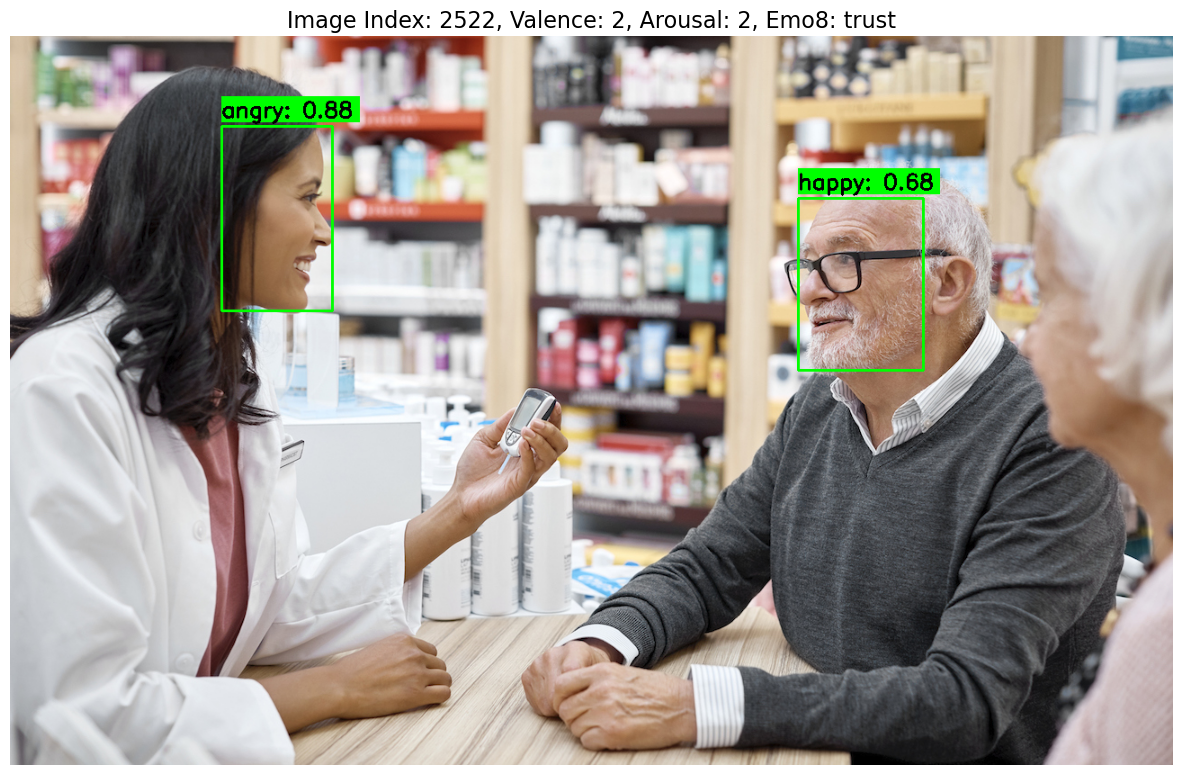

Base model (365 categories):
  pharmacy: 0.6783
  drugstore: 0.2883
  biology_laboratory: 0.0091

Mapped model (20 categories):
  indoor (5): 0.9848
  community (4): 0.0083
  busy_social (1): 0.0042


In [331]:
# pick random element from train_indices 12211 is a good one
random_sample = random.choice(train_indices)
show_pretrained_model_predictions_on_sample(random_sample)

In [332]:
def show_images_with_context(context = None, threshold = 0.10, indices = train_indices, max_images=10):
    found_with_context = 0
    random.shuffle(indices)
    print(len(indices))
    for sample_idx in indices:
        scene_tensor = train_scenes_dataset[(sample_idx,)]

        with torch.no_grad():
            mapped_output = scene_model(scene_tensor.unsqueeze(0).to(DEVICE))[0]

        top3_mapped = torch.topk(mapped_output, 3)
        top3_categories = [mapped_categories[idx.item()] for idx in top3_mapped.indices.cpu()]

        # The probability of the context in the top 3 needs to exceed 10%
        top3_probs = torch.softmax(mapped_output, dim=0)[top3_mapped.indices]
        context_prob = 0
        if context in top3_categories:
            context_index = top3_categories.index(context)
            context_prob = top3_probs[context_index].item()

        if context is None or context_prob > threshold:
            show_pretrained_model_predictions_on_sample(sample_idx)
            found_with_context += 1
            if found_with_context >= max_images:
                    break

In [333]:
# debug_indices = [idx for idx in train_indices if df.loc[idx, 'nr_faces'] == 0]
# show_images_with_context(context="agriculture", max_images=10)

In [334]:
from deepproblog.engines import ApproximateEngine

heuristic1 = ApproximateEngine.ucs
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model5.pl"), [face_network, scene_network])
model.set_engine(ApproximateEngine(model, 10, heuristic2))
# model.set_engine(ExactEngine(model), cache=True)
model.optimizer = SGD(model, lr_model)
model.train()

In [335]:
model.add_tensor_source("faces_train", train_faces_dataset)
model.add_tensor_source("faces_test", test_faces_dataset)

model.add_tensor_source("scenes_train", train_scenes_dataset)
model.add_tensor_source("scenes_test", test_scenes_dataset)

In [ ]:
class FindingEmoDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        super(FindingEmoDataset, self).__init__()
        self.indices = indices
        self.dataset_name = dataset_name
    
    def __getitem__(self, i):
        pass
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        index = self.indices[i]
        row = df.loc[index]
        nr_faces = row['nr_faces']
        sub_images = [Term("face_{}".format(x)) for x in range(nr_faces)]
        images = [
            Term("tensor", Term(f"faces_{self.dataset_name}", Constant(index), Constant(x))) for x in range(nr_faces)
        ]

        sub = {sub_images[x]: images[x] for x in range(nr_faces)}
        return Query(
            Term(f"final_emotion_{nr_faces}",
                 list2term(sub_images),
                 Term("tensor", Term(f"scenes_{self.dataset_name}", Constant(index))),
                 Term(row['emotion'])
            ),
            substitution=sub,
        )
    
train_dataset = FindingEmoDataset(train_indices, "train")
test_dataset = FindingEmoDataset(test_indices, "test")

In [337]:
def test_query(query, model):
    results = model.solve([query])
    result = results[0].result
    print(result)

In [338]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size)

In [339]:
if load_model:
    model.load_state(os.path.join(model_dir, "model4_2_findingemo.zip"))

else:
    train_obj = train_model(
        model,
        train_loader,
        10,
        log_iter=log_iter
    )

    # save the model
    # model.save_state(os.path.join(model_dir, "model4v4.zip"))

Training  for 10 epoch(s)
Epoch 1
Iteration:  2 	s:5.4071 	Average Loss:  1.003266341984272
Iteration:  4 	s:7.7929 	Average Loss:  2.1366777811199427
Iteration:  6 	s:7.3793 	Average Loss:  2.2265106588602066
Iteration:  8 	s:6.9858 	Average Loss:  2.1755210030823946
Iteration:  10 	s:6.6958 	Average Loss:  2.191267628222704
Iteration:  12 	s:6.4845 	Average Loss:  2.090010581538081
Iteration:  14 	s:7.0541 	Average Loss:  2.0465912092477083
Iteration:  16 	s:8.0000 	Average Loss:  2.1640826277434826
Iteration:  18 	s:6.8460 	Average Loss:  2.1482369918376207
Iteration:  20 	s:6.9725 	Average Loss:  2.1004751287400723
Iteration:  22 	s:6.9367 	Average Loss:  2.119547678157687
Iteration:  24 	s:6.8322 	Average Loss:  2.1819671150296926
Iteration:  26 	s:7.8264 	Average Loss:  2.063842248171568
Iteration:  28 	s:7.7588 	Average Loss:  2.2566179502755404
Iteration:  30 	s:7.3570 	Average Loss:  2.183708591386676
Iteration:  32 	s:7.2105 	Average Loss:  2.163909938186407
Iteration:  34 	s

KeyboardInterrupt: 

In [ ]:
# from deepproblog.evaluate import get_confusion_matrix

cf = get_confusion_matrix(model, test_dataset)

In [ ]:
print(cf)

         	            	       	     	    	      Actual	       	    	     	        
         	            	sadness	anger	fear	anticipation	disgust	 joy	trust	surprise
         	     sadness	      3	    5	   1	           7	      2	  11	    3	       0
         	       anger	    491	  473	 427	        1087	    186	1311	  690	     156
         	        fear	      0	    0	   0	           0	      0	   0	    0	       0
Predicted	anticipation	      0	    0	   0	           0	      0	   0	    0	       0
         	     disgust	      0	    0	   0	           0	      0	   0	    0	       0
         	         joy	      0	    0	   0	           0	      0	   0	    0	       0
         	       trust	     18	   33	  33	          89	     11	  94	   32	      11
         	    surprise	      0	    0	   0	           0	      0	   0	    0	       0


In [ ]:
buckets = ['bucket_ll', 'bucket_lm', 'bucket_lh', 'bucket_ml', 'bucket_mm', 'bucket_mh', 'bucket_hl', 'bucket_hm', 'bucket_hh']
emotions = ['joy', 'trust', 'fear', 'surprise', 'sadness', 'disgust', 'anger', 'anticipation']

i = 0
for emotion in emotions:
    for bucket in buckets:
        print("Mapping for", bucket, "to emotion", emotion, ": ", model.parameters[i])
        i += 1

Mapping for bucket_ll to emotion joy :  0.3589793804846284
Mapping for bucket_lm to emotion joy :  0.40336318547790473
Mapping for bucket_lh to emotion joy :  0.26452086722201307
Mapping for bucket_ml to emotion joy :  0.04345044292309719
Mapping for bucket_mm to emotion joy :  1.0
Mapping for bucket_mh to emotion joy :  0.12482616285320935
Mapping for bucket_hl to emotion joy :  1.0
Mapping for bucket_hm to emotion joy :  0.41333815203171687
Mapping for bucket_hh to emotion joy :  0.2931782814070929
Mapping for bucket_ll to emotion trust :  0.6286397994944434
Mapping for bucket_lm to emotion trust :  0.9179166819259107
Mapping for bucket_lh to emotion trust :  0.3616350261669765
Mapping for bucket_ml to emotion trust :  0.1922885902566599
Mapping for bucket_mm to emotion trust :  0.4083332215590356
Mapping for bucket_mh to emotion trust :  0.6612633185677101
Mapping for bucket_hl to emotion trust :  1.0
Mapping for bucket_hm to emotion trust :  1.0
Mapping for bucket_hh to emotion tru

In [ ]:
model.parameters

[0.3589793804846284,
 0.40336318547790473,
 0.26452086722201307,
 0.04345044292309719,
 1.0,
 0.12482616285320935,
 1.0,
 0.41333815203171687,
 0.2931782814070929,
 0.6286397994944434,
 0.9179166819259107,
 0.3616350261669765,
 0.1922885902566599,
 0.4083332215590356,
 0.6612633185677101,
 1.0,
 1.0,
 0.8553177210151469,
 0.8664836667552697,
 0.4017013997419414,
 0.4534103023684355,
 0.8341104266407503,
 0.3889787034063579,
 0.3552707002275215,
 1.0,
 0.8245723284572472,
 0.6835476655366672,
 0.07140250957854832,
 0.6422433848801736,
 0.534139877029708,
 0.24481092515142622,
 0.5377622486162171,
 0.269947826784278,
 1.0,
 0.7294249255014913,
 0.21961517397026897,
 0.32428273441532185,
 0.7938682540397997,
 0.05593794754928394,
 0.8218025940068083,
 1.0,
 0.40116478702232894,
 0.9172677341269913,
 1.0,
 0.5671800514785023,
 0.717914270718976,
 0.22592476061923072,
 0.4992312594922773,
 0.8846831538867025,
 0.7833425919078894,
 0.14287159044206266,
 0.5811899548610858,
 0.820607561973454

{final_emotion_0([],tensor(scenes_train(18312)),sadness): tensor(0.8741, device='cuda:0', grad_fn=<AddBackward0>), final_emotion_0([],tensor(scenes_train(18312)),fear): tensor(0.8741, device='cuda:0', grad_fn=<AddBackward0>), final_emotion_0([],tensor(scenes_train(18312)),joy): tensor(0.3660, device='cuda:0', grad_fn=<MulBackward0>), final_emotion_0([],tensor(scenes_train(18312)),trust): tensor(0.3660, device='cuda:0', grad_fn=<MulBackward0>), final_emotion_0([],tensor(scenes_train(18312)),surprise): tensor(0.7492, device='cuda:0', grad_fn=<MulBackward0>), final_emotion_0([],tensor(scenes_train(18312)),disgust): tensor(0.8042, device='cuda:0', grad_fn=<MulBackward0>), final_emotion_0([],tensor(scenes_train(18312)),anticipation): tensor(0.8134, device='cuda:0', grad_fn=<SelectBackward0>), final_emotion_0([],tensor(scenes_train(18312)),anger): tensor(0.8134, device='cuda:0', grad_fn=<SelectBackward0>)}


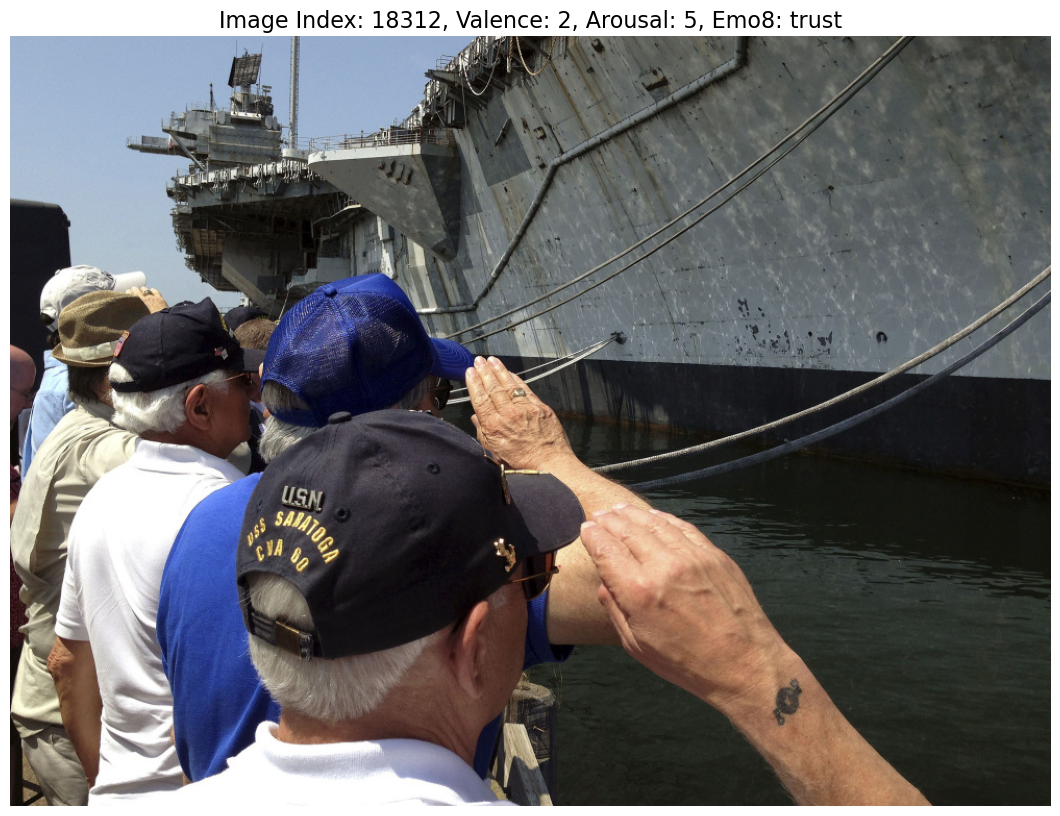

Base model (365 categories):
  lock_chamber: 0.8028
  dam: 0.0550
  moat_water: 0.0249

Mapped model (20 categories):
  urban_strain_discomfort: 0.8134
  lively_social_gathering_places: 0.0607
  peaceful_natural_retreats: 0.0550


In [ ]:
# index = random.choice(train_indices)
# row = df.loc[index]
# nr_faces = row['nr_faces']
# sub_images = [Term("face_{}".format(x)) for x in range(nr_faces)]
# images = [
#     Term("tensor", Term("faces_train", Constant(index), Constant(x))) for x in range(nr_faces)
# ]

# sub = {sub_images[x]: images[x] for x in range(nr_faces)}
# query = Query(
#     Term(f"final_emotion_{nr_faces}",
#             list2term(sub_images),
#             Term("tensor", Term(f"scenes_train", Constant(index))),
#             # Term(row['emo8'])
#             Var("E")
#     ),
#     substitution=sub,
# )
# test_query(query, model)
# show_pretrained_model_predictions_on_sample(index)


In [ ]:
# if load_model:
#     model.load_state(os.path.join(model_dir, "model4_2_findingemo.zip"))

In [ ]:
# get_confusion_matrix(model, test_dataset, verbose=1)